Filter metadata and files based in the counts of run per BioProject.

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [34]:
sugarcane_rna_df = pd.read_csv('../data/sugarcane_with_pmid_with_articles_with_dois.csv',
                               header=0, low_memory=False)
sugarcane_dna_df = pd.read_csv('../data/sugarcane_dna_with_pmid_with_articles_with_dois.csv',
                               header=0, low_memory=False)

citrus_rna_df = pd.read_csv('../data/citrus_with_pmid_with_articles_with_dois.csv',
                            header=0, low_memory=False)
citrus_dna_df = pd.read_csv('../data/citrus_dna_with_pmid_with_articles_with_dois.csv',
                            header=0, low_memory=False)

In [36]:
# check the LibrarySource column values
print("Sugarcane DNA LibrarySource values:")
print(sugarcane_dna_df['LibrarySource'].value_counts())
print("\nCitrus DNA LibrarySource values:")
print(citrus_dna_df['LibrarySource'].value_counts())

Sugarcane DNA LibrarySource values:
LibrarySource
GENOMIC        2671
METAGENOMIC    2647
Name: count, dtype: int64

Citrus DNA LibrarySource values:
LibrarySource
METAGENOMIC    5479
GENOMIC        5021
Name: count, dtype: int64


In [37]:
# First filtering step: in DNA datasets, keep only 'METAGENOMIC' in the LibrarySource column
sugarcane_dna_df = sugarcane_dna_df[sugarcane_dna_df['LibrarySource'] == 'METAGENOMIC']
citrus_dna_df = citrus_dna_df[citrus_dna_df['LibrarySource'] == 'METAGENOMIC']

In [38]:
# Count the number of runs per BioProject
sugarcane_rna_counts = sugarcane_rna_df['BioProject'].value_counts()
sugarcane_dna_counts = sugarcane_dna_df['BioProject'].value_counts()
citrus_rna_counts = citrus_rna_df['BioProject'].value_counts()
citrus_dna_counts = citrus_dna_df['BioProject'].value_counts()


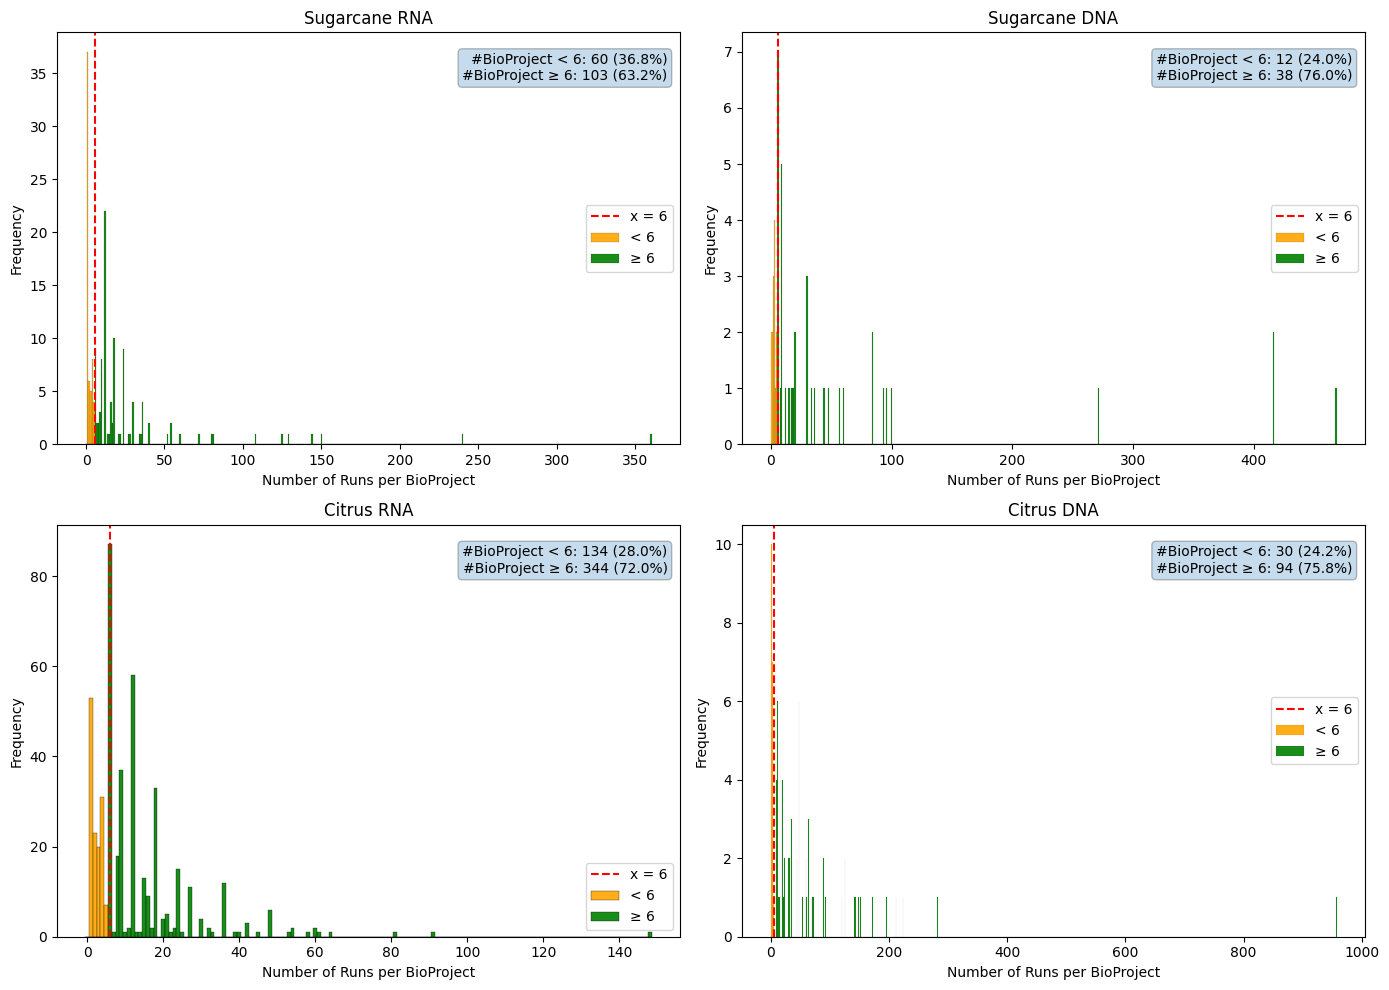

In [39]:
datasets = [
    (sugarcane_rna_counts, 'Sugarcane RNA'),
    (sugarcane_dna_counts, 'Sugarcane DNA'),
    (citrus_rna_counts, 'Citrus RNA'),
    (citrus_dna_counts,     'Citrus DNA')  
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for ax, (counts, label) in zip(axes, datasets):
    counts = np.asarray(counts)
    if counts.size == 0:
        ax.text(0.5, 0.5, 'No data', transform=ax.transAxes, ha='center', va='center')
        ax.set_title(label)
        continue

    # Use integer-centered bins (good for "counts" data)
    xmin = 0
    xmax = counts.max()
    bins = np.arange(xmin - 0.5, xmax + 1.5, 1)  # centers bins on integers

    # Split data into <=6 and >6 so we can color them separately
    mask_le6 = counts < 6
    mask_gt6 = counts >= 6

    # Plot the two parts (they don't double-count because masks partition the data)
    sns.histplot(counts[mask_le6], bins=bins, ax=ax, kde=False, label='< 6', alpha=0.9, color = 'orange')
    if mask_gt6.sum() > 0:
        sns.histplot(counts[mask_gt6], bins=bins, ax=ax, kde=False, label='≥ 6', alpha=0.9, color = 'green')

    # mark x=6 and set log scale for y
    ax.axvline(6, color='red', linestyle='--', linewidth=1.5, label='x = 6')
    # ax.set_yscale('log')

    # labels & title
    ax.set_xlabel('Number of Runs per BioProject')
    # ax.set_ylabel('Frequency (log scale)')
    ax.set_ylabel('Frequency')
    ax.set_title(label)

    # compute percentile: percent of values <= 6
    # Count how many values are >= 6 and present in the plot
    count_le6 = np.sum(counts < 6)
    pct_le6 = (count_le6 / counts.size) * 100
    count_ge6 = np.sum(counts >= 6)
    pct_ge6 = (count_ge6 / counts.size) * 100

    ax.text(
        0.98, 0.95,
        f'#BioProject < 6: {count_le6} ({pct_le6:.1f}%)\n#BioProject ≥ 6: {count_ge6} ({pct_ge6:.1f}%)',
        transform=ax.transAxes, ha='right', va='top',
        bbox=dict(boxstyle='round', alpha=0.25)
    )

    ax.legend()

# If you supplied fewer than 4 datasets, turn off remaining axes
if len(datasets) < len(axes):
    for ax in axes[len(datasets):]:
        ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Filter the dataframes with BioProjects with at least 6 runs
def filter_bioprojects_with_min_runs(df, bioproject_col='BioProject', min_runs=6):
    """
    Keep only rows where the BioProject has at least `min_runs` entries.
    """
    counts = df[bioproject_col].value_counts()
    valid_projects = counts[counts >= min_runs].index
    filtered_df = df[df[bioproject_col].isin(valid_projects)]
    return filtered_df

In [41]:
sugarcane_rna_filtered = filter_bioprojects_with_min_runs(sugarcane_rna_df)
sugarcane_dna_filtered = filter_bioprojects_with_min_runs(sugarcane_dna_df)
citrus_rna_filtered    = filter_bioprojects_with_min_runs(citrus_rna_df)
citrus_dna_filtered    = filter_bioprojects_with_min_runs(citrus_dna_df)

In [46]:
def validate_filtering(df, fdf, name, min_runs=6):
    """
    Validate that filtering worked correctly by showing BioProject size distributions.
    """
    print(f"\n{'='*60}")
    print(f"{name}")
    print(f"{'='*60}")
    
    # Count runs per BioProject in original data
    original_counts = df['BioProject'].value_counts()
    
    # Separate into should-be-kept vs should-be-removed
    should_keep = original_counts[original_counts >= min_runs]
    should_remove = original_counts[original_counts < min_runs]
    
    print(f"\nORIGINAL DATA:")
    print(f"  Total BioProjects: {len(original_counts)}")
    print(f"  BioProjects with >= {min_runs} runs: {len(should_keep)} (should KEEP)")
    print(f"  BioProjects with < {min_runs} runs: {len(should_remove)} (should REMOVE)")
    print(f"  Total rows: {len(df):,}")
    print(f"  Rows in projects >= {min_runs}: {should_keep.sum():,}")
    print(f"  Rows in projects < {min_runs}: {should_remove.sum():,}")
    
    # Count runs per BioProject in filtered data
    filtered_counts = fdf['BioProject'].value_counts()
    
    print(f"\nFILTERED DATA:")
    print(f"  Total BioProjects: {len(filtered_counts)}")
    print(f"  Total rows: {len(fdf):,}")
    print(f"  Min runs per project: {filtered_counts.min()}")
    print(f"  Max runs per project: {filtered_counts.max()}")
    
    # VALIDATION CHECKS
    print(f"\nVALIDATION:")
    
    # Check 1: All filtered projects should have >= min_runs
    invalid_projects = filtered_counts[filtered_counts < min_runs]
    if len(invalid_projects) > 0:
        print(f"  ❌ ERROR: {len(invalid_projects)} projects with < {min_runs} runs found!")
        print(f"     {invalid_projects}")
    else:
        print(f"  ✓ All filtered projects have >= {min_runs} runs")
    
    # Check 2: Row counts should match
    expected_rows = should_keep.sum()
    actual_rows = len(fdf)
    if expected_rows == actual_rows:
        print(f"  ✓ Row count matches: {actual_rows:,} rows")
    else:
        print(f"  ❌ ERROR: Expected {expected_rows:,} rows, got {actual_rows:,}")
    
    # Check 3: Project counts should match
    expected_projects = len(should_keep)
    actual_projects = len(filtered_counts)
    if expected_projects == actual_projects:
        print(f"  ✓ Project count matches: {actual_projects} projects")
    else:
        print(f"  ❌ ERROR: Expected {expected_projects} projects, got {actual_projects}")
    
    # Show distribution
    print(f"\nDISTRIBUTION OF RUNS PER PROJECT (original):")
    print(f"  < {min_runs} runs: {len(should_remove)} projects ({should_remove.sum():,} rows) - REMOVED")
    print(f"  >= {min_runs} runs: {len(should_keep)} projects ({should_keep.sum():,} rows) - KEPT")


# Run validation for all datasets
for name, df, fdf in [
    ("Sugarcane RNA", sugarcane_rna_df, sugarcane_rna_filtered),
    ("Sugarcane DNA", sugarcane_dna_df, sugarcane_dna_filtered),
    ("Citrus RNA", citrus_rna_df, citrus_rna_filtered),
    ("Citrus DNA", citrus_dna_df, citrus_dna_filtered)
]:
    validate_filtering(df, fdf, name, min_runs=6)


Sugarcane RNA

ORIGINAL DATA:
  Total BioProjects: 163
  BioProjects with >= 6 runs: 103 (should KEEP)
  BioProjects with < 6 runs: 60 (should REMOVE)
  Total rows: 3,314
  Rows in projects >= 6: 3,198
  Rows in projects < 6: 116

FILTERED DATA:
  Total BioProjects: 103
  Total rows: 3,198
  Min runs per project: 6
  Max runs per project: 360

VALIDATION:
  ✓ All filtered projects have >= 6 runs
  ✓ Row count matches: 3,198 rows
  ✓ Project count matches: 103 projects

DISTRIBUTION OF RUNS PER PROJECT (original):
  < 6 runs: 60 projects (116 rows) - REMOVED
  >= 6 runs: 103 projects (3,198 rows) - KEPT

Sugarcane DNA

ORIGINAL DATA:
  Total BioProjects: 50
  BioProjects with >= 6 runs: 38 (should KEEP)
  BioProjects with < 6 runs: 12 (should REMOVE)
  Total rows: 2,647
  Rows in projects >= 6: 2,613
  Rows in projects < 6: 34

FILTERED DATA:
  Total BioProjects: 38
  Total rows: 2,613
  Min runs per project: 6
  Max runs per project: 468

VALIDATION:
  ✓ All filtered projects have >= 

In [47]:
# Save the filtered dataframes to new CSV files
sugarcane_rna_filtered.to_csv('../data/sugarcane_rna_filtered.csv', index=False)
sugarcane_dna_filtered.to_csv('../data/sugarcane_dna_filtered.csv', index=False)
citrus_rna_filtered.to_csv('../data/citrus_rna_filtered.csv', index=False)
citrus_dna_filtered.to_csv('../data/citrus_dna_filtered.csv', index=False)